In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
%matplotlib inline  
#from matplotlib import animation
import cartopy.crs as ccrs
from scipy.io import netcdf
from netCDF4 import num2date
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

In [2]:
path='/home/garcia/Documents/PhD/DATA/'
#mfiles=  'GOM025-GSL301.050_y1993-2012.1d_gridT.nc','GOM025-GSL301.001_y1993-2012.1d_gridT.nc'
filenames=sorted(glob.glob('/home/garcia/Documents/PhD/DATA/*.nc'))
mfiles=filenames[0:25]
mean_file= mfiles[0]
print(mean_file)
print(len(mfiles))
print(len(filenames))

/home/garcia/Documents/PhD/DATA/GOM025-GSL301.001_y1993-2012.1d_gridT.nc
25
50


## Testing the creation of datasets with open_mfdataset

In [7]:
%timeit ds = xr.open_mfdataset(filenames[:],concat_dim='ensemble')

The slowest run took 11.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 36.6 s per loop


In [8]:
%timeit ds = xr.open_mfdataset(filenames[:],concat_dim='time_counter')
#print(ds)

1 loop, best of 3: 5.46 s per loop


In [ ]:
%timeit ds = xr.open_mfdataset(filenames[:17],concat_dim='ensemble')

In [ ]:
%timeit ds = xr.open_mfdataset(filenames[:9],concat_dim='ensemble',chunks={'time_counter':2000})

In [ ]:
%timeit ds = xr.open_mfdataset(filenames[:9],concat_dim='ensemble',engine='netcdf4')

In [ ]:
ds.variables['sst']

In [ ]:
sst0 = ds.sst[1000:12000,50,50]
print(sst0.shape)

In [ ]:
sst0.plot()
print(sst0.shape)




In [ ]:
dt=sst0.load_data

In [ ]:
dt=sst0.data

In [ ]:
dt.im_class


a priori two problems : 

 - the creation of the xarray.dataset is slow. problem with concatenate ? can we accelerate this step ? 
 - accessing the data seems tobe slow. how slow as compared to netcdf4 ?

## Testing the creation of datasets with open_dataset

In [ ]:
%timeit list_dataset = [xr.open_dataset(filenames[ifile]) for ifile in range(50)]

In [ ]:
list_dataset = [xr.open_dataset(filenames[ifile]) for ifile in range(50)]

In [ ]:
list_dataset[0]['sst'][:,50,50].plot()

creating the datasets seems to be quite fast. accessing the data too. the two problems metionned above are probably related to the concatenation step.

## let's dig into the concatenation a bit 

In [ ]:
list_dataarray=[list_dataset[member]['sst'] for member in range(len([list_dataset]))]

In [ ]:
dse = xr.concat(list_dataarray[:2],'member',coords='minimal')

In [3]:
il=0
dl=1900
its=0
ss=np.zeros((7300,1))
mlo=[55]
mla=[88]
for item in mlo:
    ids=0
    
    for item in mfiles:
        mean_file=mfiles[ids] 
        ds = xr.open_dataset(mean_file)
        #print(ds.ssh.shape)
        ids=ids+1
        #print('ensemble%s',ids)
        lats = xr.open_dataset(mean_file)['nav_lat']   
        lons = xr.open_dataset(mean_file)['nav_lon']
        time = xr.open_dataset(mean_file)['time_counter']
        
        st1=np.squeeze(ds.ssh[:,mla,mlo].values,axis=2)
        #print(st1.shape)
        #print(ss.shape)
        ss=np.concatenate((ss,st1),axis=1)
        
    its=its+1
    
    
print('finish')
    
#fig.savefig('test%s.pdf' %sta)


        
        
  


finish


In [4]:
print(ss.shape)


(7300, 26)


(15,)
[-0.13382572 -0.08322046 -0.0326152   0.01799006  0.06859533  0.11920059
  0.16980585  0.22041111  0.27101637  0.32162163  0.37222689  0.42283216
  0.47343742  0.52404268  0.57464794  0.6252532 ]


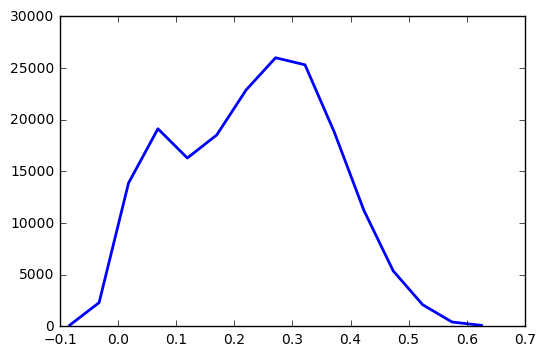

In [117]:
hist,bins=np.histogram(ss[:,1:],15)
print(hist.shape)
print(bins)


[  0.06630137   1.26356164   7.60164384  10.48164384   8.93150685
  10.15452055  12.54356164  14.24821918  13.87342466  10.28876712
   6.16109589   2.94246575   1.15178082   0.23452055   0.0569863 ]


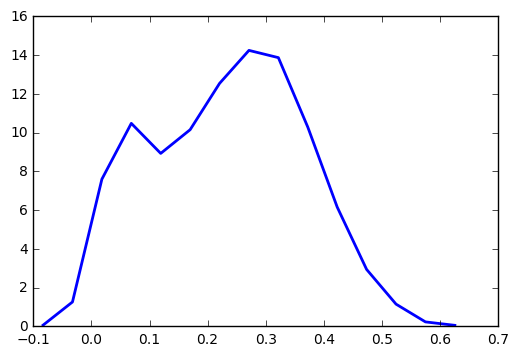

In [118]:
plt.gcf().clear()
binsT=bins
histT=hist
ste=np.cumsum(histT)
hisT=hist/float(ste[-1])*100
print(hisT)
plt.plot(bins[1:],hisT,color='blue',linestyle='solid',linewidth=2)
plt.show()

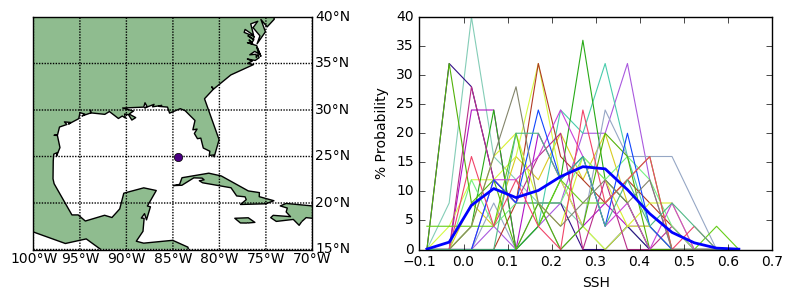

In [121]:
it=720
fig=plt.figure(figsize=(10.0,3.0))
axes1=fig.add_subplot(1,2,1)
llcrnrlon = -100
llcrnrlat = 15
urcrnrlon = -70
urcrnrlat = 40
proj='cyl'
m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                projection=proj)
m.fillcontinents(color='darkseagreen')
my, mx =m(lats[mla,mlo],lons[mla,mlo])#mx,my= m(24,-85)
parallels = np.arange(-100.,81.,5.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(0.,351.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])
m.drawcoastlines()
m.plot(mx,my,color='indigo',marker='o',markersize=6)
axes2=fig.add_subplot(1,2,2)
axes2.set_ylabel('% Probability')
axes2.set_xlabel('SSH')

for item in range(20):
    hist,bins=np.histogram(ss[it,1:],binsT)
    ste=np.cumsum(hist)
    his=hist/float(ste[-1])*100
    colorgr=(np.random.random(3))
    axes2.plot(binsT[1:],his,color=colorgr,linestyle='solid',linewidth=0.8)
    it=it+90
    plt.axis()
    #plt.hold(True)
    
axes2.plot(binsT[1:],hisT,color='blue',linestyle='solid',linewidth=2)
plt.show()


In [91]:
plt.show()
fig.savefig('pdftest.pdf')